In [118]:
!pip install xlrd
!pip install --upgrade xlrd
# pd.set_option("display.max_rows", None)

from IPython.display import clear_output
clear_output()

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import math

In [2]:
# read cleaned dataset
df = pd.read_parquet('1985_Accidents_UK_cleaned.parquet', engine='pyarrow')
print(df.columns)
print(df.shape)

Index(['location_easting_osgr', 'location_northing_osgr', 'police_force',
       'accident_severity', 'number_of_vehicles', 'number_of_casualties',
       'day_of_week', 'first_road_class', 'first_road_number', 'speed_limit',
       'junction_control', 'second_road_class', 'second_road_number',
       'light_conditions', 'drv_day_number', 'drv_month_number', 'hour',
       'week_number', 'road_type_Single carriageway',
       'road_type_Dual carriageway', 'road_type_Roundabout',
       'road_type_One way street/Slip road',
       'junction_detail_Not at junction or within 20 metres',
       'junction_detail_T or staggered junction', 'junction_detail_Other',
       'sencond_road_class', 'local_authority_district_code',
       'local_authority_district_name'],
      dtype='object')
(245518, 28)


In [3]:
accident_everity_encoded = df.replace({'accident_severity': {'Slight': 0, 'Serious': 1, 'Fatal': 2}})
df['accident_severity'] = accident_everity_encoded['accident_severity']

In [4]:
df

,location_easting_osgr,location_northing_osgr,police_force,accident_severity,number_of_vehicles,number_of_casualties,day_of_week,first_road_class,first_road_number,speed_limit,...,road_type_Single carriageway,road_type_Dual carriageway,road_type_Roundabout,road_type_One way street/Slip road,junction_detail_Not at junction or within 20 metres,junction_detail_T or staggered junction,junction_detail_Other,sencond_road_class,local_authority_district_code,local_authority_district_name
accident_index,,,,,,,,,,,,,,,,,,,,,
198501AD00001,530180.0,179670.0,29,0,1.0,1.0,0,4,3214.0,30.0,...,1,0,0,0,0,0,1,4,0,330
198501AD00002,530020.0,180510.0,29,0,2.0,1.0,4,4,4.0,30.0,...,0,0,0,1,1,0,0,0,0,330
198501AD00003,528360.0,179760.0,29,0,2.0,1.0,5,4,4.0,30.0,...,0,0,0,1,0,0,1,3,0,330
198501AD00004,530400.0,180290.0,29,0,2.0,1.0,4,3,308.0,30.0,...,0,1,0,0,0,0,1,4,0,330
198501AD00005,530150.0,179690.0,29,0,1.0,1.0,3,4,3214.0,30.0,...,1,0,0,0,1,0,0,0,0,330
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
198598T038776,311600.0,605300.0,11,0,2.0,1.0,6,4,708.0,60.0,...,1,0,0,0,1,0,0,0,859,0
198598T038877,298400.0,576300.0,11,0,1.0,1.0,6,4,75.0,30.0,...,1,0,0,0,0,1,0,1,858,0
198598T038978,200010.0,504790.0,11,1,1.0,2.0,4,3,798.0,60.0,...,1,0,0,0,1,0,0,0,856,0


In [5]:
# Use our encoding look-up table to get local authority distrcit names 
la_encoding= pd.read_csv('LA_encoding.csv').set_index('code')
la_encoding.name = la_encoding.name.str.strip()
la_encoding.head()

,name
code,
0,No Name Recorded
19,Birmingham
330,Westminster
167,Manchester
154,Leeds


In [6]:
# convert encodings to dictionary key: code value: name
la_dict = la_encoding.to_dict().get('name')

In [7]:
# convert encodings to dictionary key: name value: code
la_encoding_reversed = la_encoding.copy()
la_encoding_reversed = la_encoding_reversed.reset_index()
la_encoding_reversed = la_encoding_reversed.set_index('name')
la_dict_reversed = la_encoding_reversed.to_dict().get('code')

In [8]:
df['local_authority_district_name'] = df['local_authority_district_name'].astype('int')
df['local_authority_district_name']= df['local_authority_district_name'].map(la_dict)

In [9]:
df['local_authority_district_name']

accident_index
198501AD00001         Westminster
198501AD00002         Westminster
198501AD00003         Westminster
198501AD00004         Westminster
198501AD00005         Westminster
                       ...       
198598T038776    No Name Recorded
198598T038877    No Name Recorded
198598T038978    No Name Recorded
198598T039079    No Name Recorded
198598T039180    No Name Recorded
Name: local_authority_district_name, Length: 245518, dtype: object

In [127]:
# remove anything after the comma for example: "city of".
df['local_authority_district_name'] = df['local_authority_district_name'].str.rsplit(',', n=1).str.get(0)

### Missing local authority district 

Some of the local authority districts have no name (denoted as "No name recorded"). We attempt to fill these values with an external dataset that contains the old local authority codes and their corresponding local authority names. https://assets.publishing.service.gov.uk/government/uploads/system/uploads/attachment_data/file/774860/Local_authority_and_regional_breakdown_January_2019.csv/preview

In [128]:
# importing the dataset
LAD_codes_names = pd.read_csv('Local_authority_and_regional_breakdown_January_2019.csv').set_index('Local authority')

In [129]:
#converting the data toa  dictionary to easily map it later to missing values
lad_code_name_dict = LAD_codes_names.to_dict().get('Unnamed: 1')

In [130]:
df = df.reset_index()

In [131]:
#get all districts' codes that has no name recorded
no_district_name = df[df['local_authority_district_name'].str.contains("No Name Recorded")]
no_district_name['local_authority_district_code'] = no_district_name['local_authority_district_code'].astype('int')
clear_output()
print(len(no_district_name))

37830


In [132]:
no_district_name['local_authority_district_name'] = no_district_name['local_authority_district_code'].map(lad_code_name_dict)
clear_output()

In [133]:
no_district_name['local_authority_district_name'].isnull().sum()

26603

In [134]:
no_district_name = no_district_name.set_index('accident_index')

In [135]:
df = df.set_index('accident_index')

In [136]:
((no_district_name['local_authority_district_name'].isnull()).sum()/len(no_district_name))*100

70.32249537404176

% of local authority districts still missing names is 70.32%

In [137]:
df.update(no_district_name)

In [138]:
df

,location_easting_osgr,location_northing_osgr,police_force,accident_severity,number_of_vehicles,number_of_casualties,day_of_week,first_road_class,first_road_number,speed_limit,...,road_type_Single carriageway,road_type_Dual carriageway,road_type_Roundabout,road_type_One way street/Slip road,junction_detail_Not at junction or within 20 metres,junction_detail_T or staggered junction,junction_detail_Other,sencond_road_class,local_authority_district_code,local_authority_district_name
accident_index,,,,,,,,,,,,,,,,,,,,,
198501AD00001,530180.0,179670.0,29,0.0,1.0,1.0,0,4,3214.0,30.0,...,1,0,0,0,0,0,1,4,0,Westminster
198501AD00002,530020.0,180510.0,29,0.0,2.0,1.0,4,4,4.0,30.0,...,0,0,0,1,1,0,0,0,0,Westminster
198501AD00003,528360.0,179760.0,29,0.0,2.0,1.0,5,4,4.0,30.0,...,0,0,0,1,0,0,1,3,0,Westminster
198501AD00004,530400.0,180290.0,29,0.0,2.0,1.0,4,3,308.0,30.0,...,0,1,0,0,0,0,1,4,0,Westminster
198501AD00005,530150.0,179690.0,29,0.0,1.0,1.0,3,4,3214.0,30.0,...,1,0,0,0,1,0,0,0,0,Westminster
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
198598T038776,311600.0,605300.0,11,0.0,2.0,1.0,6,4,708.0,60.0,...,1,0,0,0,1,0,0,0,859.0,No Name Recorded
198598T038877,298400.0,576300.0,11,0.0,1.0,1.0,6,4,75.0,30.0,...,1,0,0,0,0,1,0,1,858.0,No Name Recorded
198598T038978,200010.0,504790.0,11,1.0,1.0,2.0,4,3,798.0,60.0,...,1,0,0,0,1,0,0,0,856.0,Leicester


### isUrban

The original dataset has a feature determining whether the accident oocured in a rural or an urban area, but all its values for all rows were null, thus we dropped it.

Now, we attempt to create a similar feature determining whether the area in which the accident occured is urban or not using an external dataset found here (https://webarchive.nationalarchives.gov.uk/ukgwa/20160105160709/http://www.ons.gov.uk/ons/guide-method/census/census-2001/data-and-products/data-and-product-catalogue/local-statistics/census-area-statistics-for-urban-areas-in-england-and-wales/list-of-urban-area-names-and-codes.xls)

This dataset contains only urban area names. we try to match the names of the local authority districts in our dataset with these names to see which areas are urban, and add an indicator variable

In [139]:
#importing dataset
df_urban = pd.read_excel('urbancode_tcm77-208307.xls')

In [140]:
df_urban

,Urban area code,Urban area name
0,D33700,Accrington Urban Area
1,D33701,Accrington
2,D33703,Church
3,D33704,Clayton-le-moors
4,D33705,Great Harwood
...,...,...
2615,E72902,Brymbo/Gwersyllt
2616,E72903,Rhostyllen
2617,E72901,Wrexham
2618,K01700,Ynysybwl


In [141]:
df_urban = df_urban.drop_duplicates('Urban area name')

In [142]:
df = df.reset_index()

In [143]:
#merging on area name and local authority district name
df_FE_urban = pd.merge(left=df, right=df_urban['Urban area name'], left_on='local_authority_district_name', right_on='Urban area name', how='left')

In [144]:
df_FE_urban

,accident_index,location_easting_osgr,location_northing_osgr,police_force,accident_severity,number_of_vehicles,number_of_casualties,day_of_week,first_road_class,first_road_number,...,road_type_Dual carriageway,road_type_Roundabout,road_type_One way street/Slip road,junction_detail_Not at junction or within 20 metres,junction_detail_T or staggered junction,junction_detail_Other,sencond_road_class,local_authority_district_code,local_authority_district_name,Urban area name
0,198501AD00001,530180.0,179670.0,29,0.0,1.0,1.0,0,4,3214.0,...,0,0,0,0,0,1,4,0,Westminster,Westminster
1,198501AD00002,530020.0,180510.0,29,0.0,2.0,1.0,4,4,4.0,...,0,0,1,1,0,0,0,0,Westminster,Westminster
2,198501AD00003,528360.0,179760.0,29,0.0,2.0,1.0,5,4,4.0,...,0,0,1,0,0,1,3,0,Westminster,Westminster
3,198501AD00004,530400.0,180290.0,29,0.0,2.0,1.0,4,3,308.0,...,1,0,0,0,0,1,4,0,Westminster,Westminster
4,198501AD00005,530150.0,179690.0,29,0.0,1.0,1.0,3,4,3214.0,...,0,0,0,1,0,0,0,0,Westminster,Westminster
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
245513,198598T038776,311600.0,605300.0,11,0.0,2.0,1.0,6,4,708.0,...,0,0,0,1,0,0,0,859.0,No Name Recorded,NaN
245514,198598T038877,298400.0,576300.0,11,0.0,1.0,1.0,6,4,75.0,...,0,0,0,0,1,0,1,858.0,No Name Recorded,NaN
245515,198598T038978,200010.0,504790.0,11,1.0,1.0,2.0,4,3,798.0,...,0,0,0,1,0,0,0,856.0,Leicester,Leicester
245516,198598T039079,319900.0,568900.0,11,1.0,1.0,1.0,5,3,722.0,...,0,0,0,1,0,0,0,859.0,No Name Recorded,NaN


In [145]:
df_FE_urban.columns

Index(['accident_index', 'location_easting_osgr', 'location_northing_osgr',
       'police_force', 'accident_severity', 'number_of_vehicles',
       'number_of_casualties', 'day_of_week', 'first_road_class',
       'first_road_number', 'speed_limit', 'junction_control',
       'second_road_class', 'second_road_number', 'light_conditions',
       'drv_day_number', 'drv_month_number', 'hour', 'week_number',
       'road_type_Single carriageway', 'road_type_Dual carriageway',
       'road_type_Roundabout', 'road_type_One way street/Slip road',
       'junction_detail_Not at junction or within 20 metres',
       'junction_detail_T or staggered junction', 'junction_detail_Other',
       'sencond_road_class', 'local_authority_district_code',
       'local_authority_district_name', 'Urban area name'],
      dtype='object')

In [146]:
df_FE_urban['isUrban'] = np.where(df_FE_urban['Urban area name'].isnull(), 0, 1)

In [147]:
df_FE_urban['isUrban'].value_counts()

1    137738
0    107780
Name: isUrban, dtype: int64

133191 accidents in our dataset occured in an urban area

In [148]:
df = df_FE_urban.copy()

In [149]:
del df['Urban area name']

In [10]:
df.index

Index(['198501AD00001', '198501AD00002', '198501AD00003', '198501AD00004',
       '198501AD00005', '198501AD00006', '198501AD00007', '198501AD00008',
       '198501AD00009', '198501AD00010',
       ...
       '198598T036271', '198598T036372', '198598T038473', '198598T038574',
       '198598T038675', '198598T038776', '198598T038877', '198598T038978',
       '198598T039079', '198598T039180'],
      dtype='object', name='accident_index', length=245518)

#### Encoding


In [150]:
df['local_authority_district_name']= df['local_authority_district_name'].map(la_dict_reversed)
df['local_authority_district_name'].value_counts()
df

,accident_index,location_easting_osgr,location_northing_osgr,police_force,accident_severity,number_of_vehicles,number_of_casualties,day_of_week,first_road_class,first_road_number,...,road_type_Dual carriageway,road_type_Roundabout,road_type_One way street/Slip road,junction_detail_Not at junction or within 20 metres,junction_detail_T or staggered junction,junction_detail_Other,sencond_road_class,local_authority_district_code,local_authority_district_name,isUrban
0,198501AD00001,530180.0,179670.0,29,0.0,1.0,1.0,0,4,3214.0,...,0,0,0,0,0,1,4,0,330.0,1
1,198501AD00002,530020.0,180510.0,29,0.0,2.0,1.0,4,4,4.0,...,0,0,1,1,0,0,0,0,330.0,1
2,198501AD00003,528360.0,179760.0,29,0.0,2.0,1.0,5,4,4.0,...,0,0,1,0,0,1,3,0,330.0,1
3,198501AD00004,530400.0,180290.0,29,0.0,2.0,1.0,4,3,308.0,...,1,0,0,0,0,1,4,0,330.0,1
4,198501AD00005,530150.0,179690.0,29,0.0,1.0,1.0,3,4,3214.0,...,0,0,0,1,0,0,0,0,330.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
245513,198598T038776,311600.0,605300.0,11,0.0,2.0,1.0,6,4,708.0,...,0,0,0,1,0,0,0,859.0,0.0,0
245514,198598T038877,298400.0,576300.0,11,0.0,1.0,1.0,6,4,75.0,...,0,0,0,0,1,0,1,858.0,0.0,0
245515,198598T038978,200010.0,504790.0,11,1.0,1.0,2.0,4,3,798.0,...,0,0,0,1,0,0,0,856.0,155.0,1
245516,198598T039079,319900.0,568900.0,11,1.0,1.0,1.0,5,3,722.0,...,0,0,0,1,0,0,0,859.0,0.0,0


In [151]:
df

,accident_index,location_easting_osgr,location_northing_osgr,police_force,accident_severity,number_of_vehicles,number_of_casualties,day_of_week,first_road_class,first_road_number,...,road_type_Dual carriageway,road_type_Roundabout,road_type_One way street/Slip road,junction_detail_Not at junction or within 20 metres,junction_detail_T or staggered junction,junction_detail_Other,sencond_road_class,local_authority_district_code,local_authority_district_name,isUrban
0,198501AD00001,530180.0,179670.0,29,0.0,1.0,1.0,0,4,3214.0,...,0,0,0,0,0,1,4,0,330.0,1
1,198501AD00002,530020.0,180510.0,29,0.0,2.0,1.0,4,4,4.0,...,0,0,1,1,0,0,0,0,330.0,1
2,198501AD00003,528360.0,179760.0,29,0.0,2.0,1.0,5,4,4.0,...,0,0,1,0,0,1,3,0,330.0,1
3,198501AD00004,530400.0,180290.0,29,0.0,2.0,1.0,4,3,308.0,...,1,0,0,0,0,1,4,0,330.0,1
4,198501AD00005,530150.0,179690.0,29,0.0,1.0,1.0,3,4,3214.0,...,0,0,0,1,0,0,0,0,330.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
245513,198598T038776,311600.0,605300.0,11,0.0,2.0,1.0,6,4,708.0,...,0,0,0,1,0,0,0,859.0,0.0,0
245514,198598T038877,298400.0,576300.0,11,0.0,1.0,1.0,6,4,75.0,...,0,0,0,0,1,0,1,858.0,0.0,0
245515,198598T038978,200010.0,504790.0,11,1.0,1.0,2.0,4,3,798.0,...,0,0,0,1,0,0,0,856.0,155.0,1
245516,198598T039079,319900.0,568900.0,11,1.0,1.0,1.0,5,3,722.0,...,0,0,0,1,0,0,0,859.0,0.0,0


### Adding counts of males and females involved in each accident

We found this resource that contained multiple datasets for UK accidents in the year 1985. We imported the needed datasets to get some stats about the gender of the drivers

(https://www.opendatablend.io/dataset/?name=open-data-blend-road-safety)

In [152]:
accidents_uk = df.copy()

In [153]:
accidents_uk

,accident_index,location_easting_osgr,location_northing_osgr,police_force,accident_severity,number_of_vehicles,number_of_casualties,day_of_week,first_road_class,first_road_number,...,road_type_Dual carriageway,road_type_Roundabout,road_type_One way street/Slip road,junction_detail_Not at junction or within 20 metres,junction_detail_T or staggered junction,junction_detail_Other,sencond_road_class,local_authority_district_code,local_authority_district_name,isUrban
0,198501AD00001,530180.0,179670.0,29,0.0,1.0,1.0,0,4,3214.0,...,0,0,0,0,0,1,4,0,330.0,1
1,198501AD00002,530020.0,180510.0,29,0.0,2.0,1.0,4,4,4.0,...,0,0,1,1,0,0,0,0,330.0,1
2,198501AD00003,528360.0,179760.0,29,0.0,2.0,1.0,5,4,4.0,...,0,0,1,0,0,1,3,0,330.0,1
3,198501AD00004,530400.0,180290.0,29,0.0,2.0,1.0,4,3,308.0,...,1,0,0,0,0,1,4,0,330.0,1
4,198501AD00005,530150.0,179690.0,29,0.0,1.0,1.0,3,4,3214.0,...,0,0,0,1,0,0,0,0,330.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
245513,198598T038776,311600.0,605300.0,11,0.0,2.0,1.0,6,4,708.0,...,0,0,0,1,0,0,0,859.0,0.0,0
245514,198598T038877,298400.0,576300.0,11,0.0,1.0,1.0,6,4,75.0,...,0,0,0,0,1,0,1,858.0,0.0,0
245515,198598T038978,200010.0,504790.0,11,1.0,1.0,2.0,4,3,798.0,...,0,0,0,1,0,0,0,856.0,155.0,1
245516,198598T039079,319900.0,568900.0,11,1.0,1.0,1.0,5,3,722.0,...,0,0,0,1,0,0,0,859.0,0.0,0


In [154]:
# importing datasets
vehicle_driver  = pd.read_csv("data_dimension_road_safety_vehicle_driver_20221022T080507Z_road_safety_vehicle_driver.csv")
accidents_index = pd.read_csv("data_dimension_road_safety_accident_index_20221022T074642Z_road_safety_accident_index.csv")
facts_veh_df = pd.read_csv('data_fact_road_safety_vehicle_1985_20211208T010902Z_road_safety_vehicle_1985.csv')

clear_output()

Merge 1

Merging accidents_uk and accidents_index tables on accident_index and src_accident_index

In [155]:
accidents_index.columns

Index(['nll_licence_code', 'nll_licence_name', 'nll_licence_url',
       'drv_road_safety_accident_index_key', 'nlm_dimension_load_date',
       'nlm_dimension_is_current', 'nlm_dimension_update_date',
       'nlm_effective_from_date', 'nlm_effective_to_date',
       'src_accident_index', 'src_accident_reference', 'src_accident_year'],
      dtype='object')

In [156]:
accidents_index = accidents_index[['src_accident_index','drv_road_safety_accident_index_key']]
merge1 = pd.merge(accidents_uk,accidents_index, right_on='src_accident_index',left_on='accident_index' )
merge1.columns

Index(['accident_index', 'location_easting_osgr', 'location_northing_osgr',
       'police_force', 'accident_severity', 'number_of_vehicles',
       'number_of_casualties', 'day_of_week', 'first_road_class',
       'first_road_number', 'speed_limit', 'junction_control',
       'second_road_class', 'second_road_number', 'light_conditions',
       'drv_day_number', 'drv_month_number', 'hour', 'week_number',
       'road_type_Single carriageway', 'road_type_Dual carriageway',
       'road_type_Roundabout', 'road_type_One way street/Slip road',
       'junction_detail_Not at junction or within 20 metres',
       'junction_detail_T or staggered junction', 'junction_detail_Other',
       'sencond_road_class', 'local_authority_district_code',
       'local_authority_district_name', 'isUrban', 'src_accident_index',
       'drv_road_safety_accident_index_key'],
      dtype='object')

Merge 2

Merging accidents_index and facts_veh_df on drv_road_safety_accident_index_key column


In [157]:
facts_veh_df.columns

Index(['ptc_activity_year', 'drv_road_safety_accident_index_key',
       'drv_accident_date_key', 'drv_road_safety_accident_info_key',
       'drv_road_safety_accident_location_key',
       'drv_road_safety_vehicle_driver_key',
       'drv_road_safety_vehicle_info_key', 'drv_geolocation_key',
       'drv_time_of_day_key'],
      dtype='object')

In [158]:
facts_veh_df = facts_veh_df[['drv_road_safety_accident_index_key','drv_road_safety_vehicle_driver_key']]
merge2 = pd.merge(merge1, facts_veh_df)
merge2.columns

Index(['accident_index', 'location_easting_osgr', 'location_northing_osgr',
       'police_force', 'accident_severity', 'number_of_vehicles',
       'number_of_casualties', 'day_of_week', 'first_road_class',
       'first_road_number', 'speed_limit', 'junction_control',
       'second_road_class', 'second_road_number', 'light_conditions',
       'drv_day_number', 'drv_month_number', 'hour', 'week_number',
       'road_type_Single carriageway', 'road_type_Dual carriageway',
       'road_type_Roundabout', 'road_type_One way street/Slip road',
       'junction_detail_Not at junction or within 20 metres',
       'junction_detail_T or staggered junction', 'junction_detail_Other',
       'sencond_road_class', 'local_authority_district_code',
       'local_authority_district_name', 'isUrban', 'src_accident_index',
       'drv_road_safety_accident_index_key',
       'drv_road_safety_vehicle_driver_key'],
      dtype='object')

Merge 3

Merging facts_veh_df and vehicle_driver on drv_road_safety_vehicle_driver_key

In [159]:
vehicle_driver.columns

Index(['nll_licence_code', 'nll_licence_name', 'nll_licence_url',
       'drv_road_safety_vehicle_driver_key', 'nlm_dimension_load_date',
       'nlm_dimension_is_current', 'nlm_dimension_update_date',
       'nlm_effective_from_date', 'nlm_effective_to_date',
       'src_journey_purpose_of_driver_code', 'src_journey_purpose_of_driver',
       'src_sex_of_driver_code', 'src_sex_of_driver',
       'src_age_band_of_driver_code', 'src_age_band_of_driver',
       'src_driver_imd_decile_code', 'src_driver_imd_decile',
       'src_driver_home_area_type_code', 'src_driver_home_area_type',
       'src_lsoa_of_driver_code'],
      dtype='object')

In [160]:
vehicle_driver = vehicle_driver[['drv_road_safety_vehicle_driver_key','src_sex_of_driver']]
merge3 = pd.merge(merge2,vehicle_driver)

In [161]:
merge3.columns

Index(['accident_index', 'location_easting_osgr', 'location_northing_osgr',
       'police_force', 'accident_severity', 'number_of_vehicles',
       'number_of_casualties', 'day_of_week', 'first_road_class',
       'first_road_number', 'speed_limit', 'junction_control',
       'second_road_class', 'second_road_number', 'light_conditions',
       'drv_day_number', 'drv_month_number', 'hour', 'week_number',
       'road_type_Single carriageway', 'road_type_Dual carriageway',
       'road_type_Roundabout', 'road_type_One way street/Slip road',
       'junction_detail_Not at junction or within 20 metres',
       'junction_detail_T or staggered junction', 'junction_detail_Other',
       'sencond_road_class', 'local_authority_district_code',
       'local_authority_district_name', 'isUrban', 'src_accident_index',
       'drv_road_safety_accident_index_key',
       'drv_road_safety_vehicle_driver_key', 'src_sex_of_driver'],
      dtype='object')

In [162]:
merge3

,accident_index,location_easting_osgr,location_northing_osgr,police_force,accident_severity,number_of_vehicles,number_of_casualties,day_of_week,first_road_class,first_road_number,...,junction_detail_T or staggered junction,junction_detail_Other,sencond_road_class,local_authority_district_code,local_authority_district_name,isUrban,src_accident_index,drv_road_safety_accident_index_key,drv_road_safety_vehicle_driver_key,src_sex_of_driver
0,198501AD00001,530180.0,179670.0,29,0.0,1.0,1.0,0,4,3214.0,...,0,1,4,0,330.0,1,198501AD00001,2818803,3329,Male
1,198501AD00005,530150.0,179690.0,29,0.0,1.0,1.0,3,4,3214.0,...,0,0,0,0,330.0,1,198501AD00005,2814914,3329,Male
2,198501AD00006,530400.0,179690.0,29,1.0,1.0,1.0,2,4,302.0,...,0,0,0,0,330.0,1,198501AD00006,6986078,3329,Male
3,198501AD00007,530060.0,180510.0,29,0.0,2.0,1.0,2,4,400.0,...,0,1,4,0,330.0,1,198501AD00007,101031,3329,Male
4,198501AD00012,530150.0,179960.0,29,1.0,2.0,1.0,4,4,3212.0,...,0,0,0,0,330.0,1,198501AD00012,8559465,3329,Male
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
417690,1985440GG0446,460050.0,100780.0,20,1.0,1.0,1.0,3,4,32.0,...,0,1,1,0,114.0,1,1985440GG0446,4171646,2666,Data missing or out of range
417691,198552BR00781,362010.0,168230.0,0,0.0,2.0,1.0,3,1,0.0,...,1,0,1,0,NaN,1,198552BR00781,199348,2666,Data missing or out of range
417692,198543C036045,485170.0,174940.0,45,0.0,2.0,4.0,1,5,4.0,...,0,0,0,0,28.0,0,198543C036045,6947099,3347,Data missing or out of range
417693,198543E135115,471660.0,173550.0,45,1.0,1.0,1.0,1,1,0.0,...,0,1,1,0,214.0,1,198543E135115,5142480,3347,Data missing or out of range


In [163]:
merge3['src_sex_of_driver'].value_counts()

Male                            318669
Female                           80906
Not known                        17447
Data missing or out of range       673
Name: src_sex_of_driver, dtype: int64

In [164]:
merge3['src_sex_of_driver'].replace(['Data missing or out of range'],'Not known', True)
merge3['src_sex_of_driver'].value_counts()

Male         318669
Female        80906
Not known     18120
Name: src_sex_of_driver, dtype: int64

One hot encode the gender of the driver to create 3 columns:  'src_sex_of_driver_Male', 'src_sex_of_driver_Female',
       'src_sex_of_driver_Not known'

In [165]:
def one_hot_encode(df, variable, top_x_labels):
    for label in top_x_labels:
        df[variable + '_' + label] = np.where(
            df[variable] == label, 1, 0) 


gender_list = merge3['src_sex_of_driver'].value_counts().index.tolist()
one_hot_encode(merge3, 'src_sex_of_driver', gender_list)
merge3.columns

Index(['accident_index', 'location_easting_osgr', 'location_northing_osgr',
       'police_force', 'accident_severity', 'number_of_vehicles',
       'number_of_casualties', 'day_of_week', 'first_road_class',
       'first_road_number', 'speed_limit', 'junction_control',
       'second_road_class', 'second_road_number', 'light_conditions',
       'drv_day_number', 'drv_month_number', 'hour', 'week_number',
       'road_type_Single carriageway', 'road_type_Dual carriageway',
       'road_type_Roundabout', 'road_type_One way street/Slip road',
       'junction_detail_Not at junction or within 20 metres',
       'junction_detail_T or staggered junction', 'junction_detail_Other',
       'sencond_road_class', 'local_authority_district_code',
       'local_authority_district_name', 'isUrban', 'src_accident_index',
       'drv_road_safety_accident_index_key',
       'drv_road_safety_vehicle_driver_key', 'src_sex_of_driver',
       'src_sex_of_driver_Male', 'src_sex_of_driver_Female',
       's

 We're only interested in the males and females counts in each accident. Thus we sum the one hot encoding of females and males involved in each accident separately using groupby().sum() 

 Finally, we store these in males_counts and females_counts columns in the original dataset

In [166]:
accidents_uk = accidents_uk.set_index('accident_index')

In [167]:
# del accidents_uk['males_count']
# del accidents_uk['females_count'] 

In [168]:
males_count = merge3.groupby('src_accident_index').sum()[['src_sex_of_driver_Male']]
females_count = merge3.groupby('src_accident_index').sum()[['src_sex_of_driver_Female']]

In [169]:
accidents_uk['males_count'] = males_count
accidents_uk['females_count'] = females_count

In [170]:
accidents_uk


,location_easting_osgr,location_northing_osgr,police_force,accident_severity,number_of_vehicles,number_of_casualties,day_of_week,first_road_class,first_road_number,speed_limit,...,road_type_One way street/Slip road,junction_detail_Not at junction or within 20 metres,junction_detail_T or staggered junction,junction_detail_Other,sencond_road_class,local_authority_district_code,local_authority_district_name,isUrban,males_count,females_count
accident_index,,,,,,,,,,,,,,,,,,,,,
198501AD00001,530180.0,179670.0,29,0.0,1.0,1.0,0,4,3214.0,30.0,...,0,0,0,1,4,0,330.0,1,1,0
198501AD00002,530020.0,180510.0,29,0.0,2.0,1.0,4,4,4.0,30.0,...,1,1,0,0,0,0,330.0,1,2,0
198501AD00003,528360.0,179760.0,29,0.0,2.0,1.0,5,4,4.0,30.0,...,1,0,0,1,3,0,330.0,1,1,1
198501AD00004,530400.0,180290.0,29,0.0,2.0,1.0,4,3,308.0,30.0,...,0,0,0,1,4,0,330.0,1,2,0
198501AD00005,530150.0,179690.0,29,0.0,1.0,1.0,3,4,3214.0,30.0,...,0,1,0,0,0,0,330.0,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
198598T038776,311600.0,605300.0,11,0.0,2.0,1.0,6,4,708.0,60.0,...,0,1,0,0,0,859.0,0.0,0,2,0
198598T038877,298400.0,576300.0,11,0.0,1.0,1.0,6,4,75.0,30.0,...,0,0,1,0,1,858.0,0.0,0,1,0
198598T038978,200010.0,504790.0,11,1.0,1.0,2.0,4,3,798.0,60.0,...,0,1,0,0,0,856.0,155.0,1,1,0


In [171]:
accidents_uk.columns

Index(['location_easting_osgr', 'location_northing_osgr', 'police_force',
       'accident_severity', 'number_of_vehicles', 'number_of_casualties',
       'day_of_week', 'first_road_class', 'first_road_number', 'speed_limit',
       'junction_control', 'second_road_class', 'second_road_number',
       'light_conditions', 'drv_day_number', 'drv_month_number', 'hour',
       'week_number', 'road_type_Single carriageway',
       'road_type_Dual carriageway', 'road_type_Roundabout',
       'road_type_One way street/Slip road',
       'junction_detail_Not at junction or within 20 metres',
       'junction_detail_T or staggered junction', 'junction_detail_Other',
       'sencond_road_class', 'local_authority_district_code',
       'local_authority_district_name', 'isUrban', 'males_count',
       'females_count'],
      dtype='object')

## Exploring new features

### How does severity change when area is urban?

0: Slight
1: Severe
2: Fatal

<AxesSubplot:xlabel='isUrban', ylabel='count'>

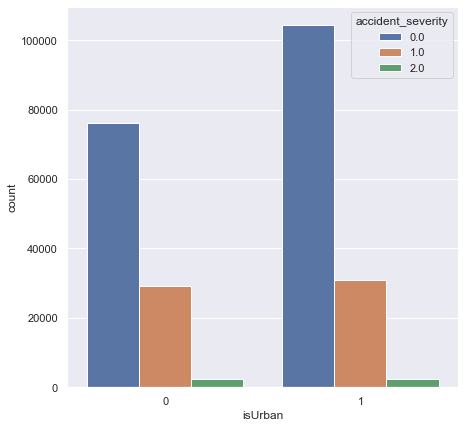

In [172]:

sns.set(rc={"figure.figsize":(7, 7)})
sns.countplot(data=accidents_uk, x="isUrban", hue="accident_severity")

There are more accidents in Urban areas than in non-urban areas. There are almost the same number of severe and fatal accidents in urban and non urban areas.

### Comparison of how many males and females were involved in accidentens in the year 1985

<BarContainer object of 2 artists>

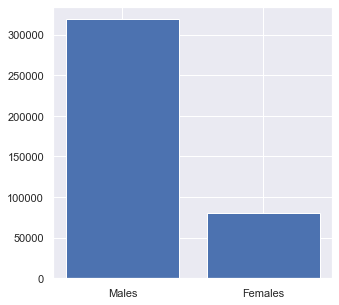

In [173]:
sns.set(rc={"figure.figsize":(5, 5)})
fig, ax  = plt.subplots()
ax.bar([1,2],[accidents_uk['males_count'].sum(), accidents_uk['females_count'].sum()],tick_label=['Males', 'Females'])

In the year 1985, more males were involved in car accidents than females

# Saving to parquet

In [176]:
accidents_uk = accidents_uk.astype(str)
accidents_uk.to_parquet('1985_Accidents_UK_cleaned_M2.parquet',index=True )